## eCommerce purchase history from electronics store

Данные о покупках с апреля 2020 года по ноябрь 2020 года в крупном онлайн-магазине бытовой техники и электроники.

Каждая строка в файле представляет собой событие. Все события связаны с товарами и пользователями. Каждое событие представляет собой отношение «многие ко многим» между товарами и пользователями.



In [ ]:
!pip uninstall numpy -y
!pip install "numpy<2" --no-cache-dir

In [2]:
!pip -q install scikit-surprise


In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.decomposition import TruncatedSVD

from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

In [106]:
DATA_PATH = "/kaggle/input/ecommerce-purchase-history-from-electronics-store/kz.csv"

df = pd.read_csv(DATA_PATH)
sns.set(style="whitegrid")

df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


Структура данных:

•	event_time — время покупки

•	order_id — идентификатор заказа

•	product_id — идентификатор товара

•	category_id, category_code — категория товара

•	brand — бренд товара

•	price — цена товара

•	user_id — идентификатор пользователя

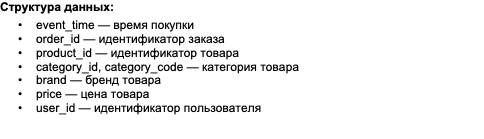
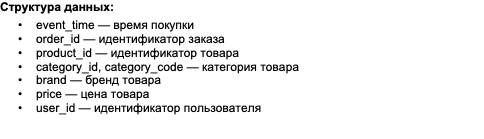
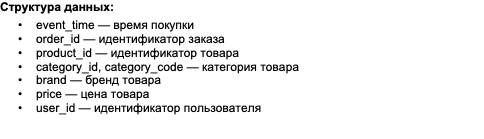
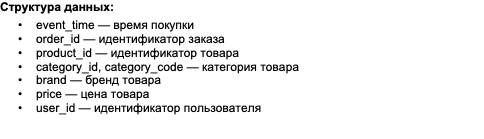

In [97]:
df.shape

(2633521, 8)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633521 entries, 0 to 2633520
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   order_id       int64  
 2   product_id     int64  
 3   category_id    float64
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        float64
dtypes: float64(3), int64(2), object(3)
memory usage: 160.7+ MB


#### Приводим event_time к временному формату

In [109]:
df["event_time"] = pd.to_datetime(df["event_time"])

In [100]:
df.nunique()

event_time       1316174
order_id         1435266
product_id         25113
category_id          900
category_code        510
brand              23021
price               2802
user_id            98262
dtype: int64

In [101]:
missing = (
    df.isna()
      .sum()
      .to_frame(name="missing_count")
      .assign(
          missing_pct=lambda x: 100 * x["missing_count"] / len(df)
      )
      .sort_values("missing_pct", ascending=False)
)

missing

,missing_count,missing_pct
user_id,2069352,78.577387
category_code,612202,23.246521
brand,506005,19.214010
category_id,431954,16.402148
price,431954,16.402148
product_id,0,0.000000
event_time,0,0.000000
order_id,0,0.000000


In [102]:
# Статистика по всем колонкам
stats = df.describe(include='all')

stats

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
count,2633521,2.633521e+06,2.633521e+06,2.201567e+06,2021319,2127516,2.201567e+06,5.641690e+05
unique,NaN,NaN,NaN,NaN,510,23021,NaN,NaN
top,NaN,NaN,NaN,NaN,electronics.smartphone,samsung,NaN,NaN
freq,NaN,NaN,NaN,NaN,357682,358928,NaN,NaN
mean,2020-01-16 19:57:05.412119808+00:00,2.361783e+18,1.674080e+18,2.273827e+18,NaN,NaN,1.540932e+02,1.515916e+18
min,1970-01-01 00:33:40+00:00,2.294360e+18,1.515966e+18,2.268105e+18,NaN,NaN,0.000000e+00,1.515916e+18
25%,2020-03-05 15:42:44+00:00,2.348807e+18,1.515966e+18,2.268105e+18,NaN,NaN,1.456000e+01,1.515916e+18
50%,2020-06-08 08:33:27+00:00,2.353254e+18,1.515966e+18,2.268105e+18,NaN,NaN,5.553000e+01,1.515916e+18
75%,2020-08-24 06:52:14+00:00,2.383131e+18,1.515966e+18,2.268105e+18,NaN,NaN,1.967400e+02,1.515916e+18
max,2020-11-21 10:10:30+00:00,2.388441e+18,2.388434e+18,2.374499e+18,NaN,NaN,5.092590e+04,1.515916e+18


Можем увидеть:

Наличие пропущенных значений в category_id, brand, price и user_id.

Значение "1970-01-01" в event_time выбивается, среднее смещено в сторону 2020


### Очистка

Удаляем строки без значений

In [107]:
df = df.dropna(subset = ["user_id", "price", "brand", "category_code"])

df.isnull().sum()

event_time       0
order_id         0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
dtype: int64

In [110]:
df = df[df["event_time"].dt.year != 1970]

df.describe(include= "all")

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
count,419890,4.198900e+05,4.198900e+05,4.198900e+05,419890,419890,419890.000000,4.198900e+05
unique,NaN,NaN,NaN,NaN,123,570,NaN,NaN
top,NaN,NaN,NaN,NaN,electronics.smartphone,samsung,NaN,NaN
freq,NaN,NaN,NaN,NaN,102169,89881,NaN,NaN
mean,2020-08-08 03:49:47.635378688+00:00,2.370509e+18,1.676753e+18,2.274301e+18,NaN,NaN,254.281619,1.515916e+18
min,2020-01-05 04:06:18+00:00,2.294360e+18,1.515966e+18,2.268105e+18,NaN,NaN,0.000000,1.515916e+18
25%,2020-07-03 09:52:22.500000+00:00,2.354505e+18,1.515966e+18,2.268105e+18,NaN,NaN,39.330000,1.515916e+18
50%,2020-08-14 08:59:07.500000+00:00,2.375487e+18,1.515966e+18,2.268105e+18,NaN,NaN,138.870000,1.515916e+18
75%,2020-10-06 14:15:43.500000+00:00,2.388441e+18,1.515966e+18,2.268105e+18,NaN,NaN,347.200000,1.515916e+18
max,2020-11-21 10:10:30+00:00,2.388441e+18,2.388434e+18,2.374499e+18,NaN,NaN,11574.050000,1.515916e+18


##### Убираем "1970-01-01"

In [111]:
start_date = pd.Timestamp('2020-01-04', tz='UTC')
end_date = pd.Timestamp('2020-11-22', tz='UTC')

df = df[(df['event_time'] >= start_date) & (df['event_time'] <= end_date)]

print(f"Минимальная дата: {df['event_time'].min()}")
print(f"Максимальная дата: {df['event_time'].max()}")
print(f"Размер: {df.shape}")

Минимальная дата: 2020-01-05 04:06:18+00:00
Максимальная дата: 2020-11-21 10:10:30+00:00
Размер: (419890, 8)


###

### Гистограмма цен

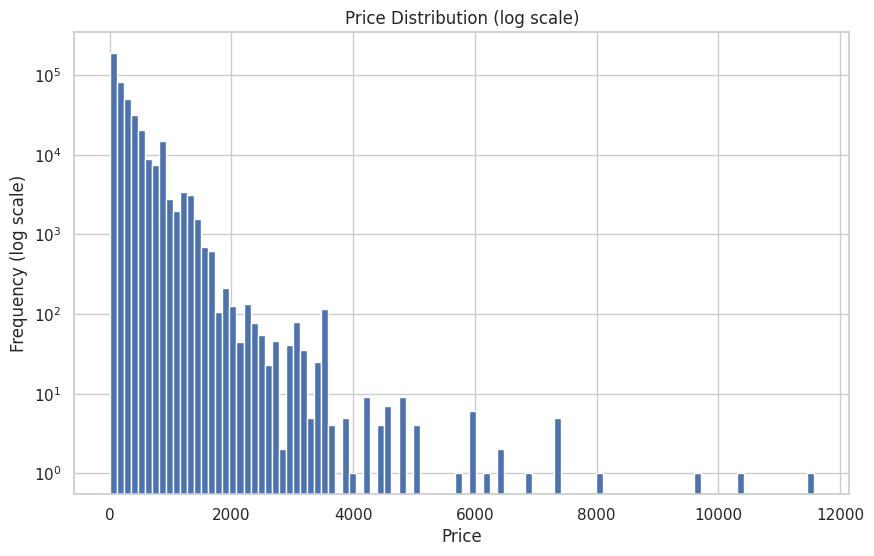

In [112]:
plt.figure(figsize=(10, 6))
plt.hist(df["price"], bins=100, log=True)
plt.title('Price Distribution (log scale)')
plt.xlabel('Price')
plt.ylabel('Frequency (log scale)')
plt.show()

### Топ-10 брендов

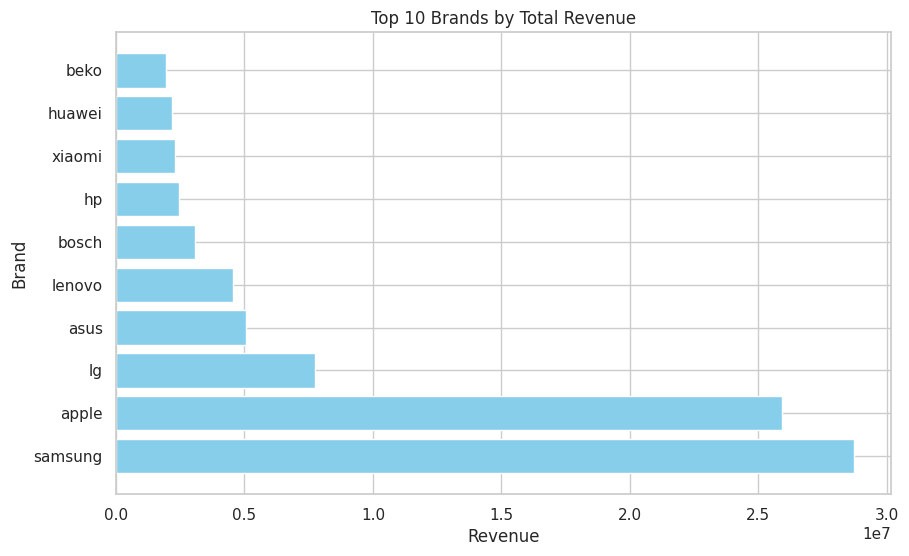

In [113]:
# Группируем данные по бренду и суммируем цены
top_10_brands = df.groupby("brand")["price"].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
plt.barh(top_10_brands["brand"], top_10_brands["price"], color="skyblue")
plt.title('Top 10 Brands by Total Revenue')
plt.xlabel('Revenue')
plt.ylabel('Brand')
plt.show()

In [114]:
# Число событий по каждому пользователю
user_event_count = df.groupby('user_id').size()

# Показать статистику: минимум, максимум, медиана
user_event_count.describe()

count    90781.000000
mean         4.625307
std         18.203522
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        461.000000
dtype: float64

### Самые покупаемые товары

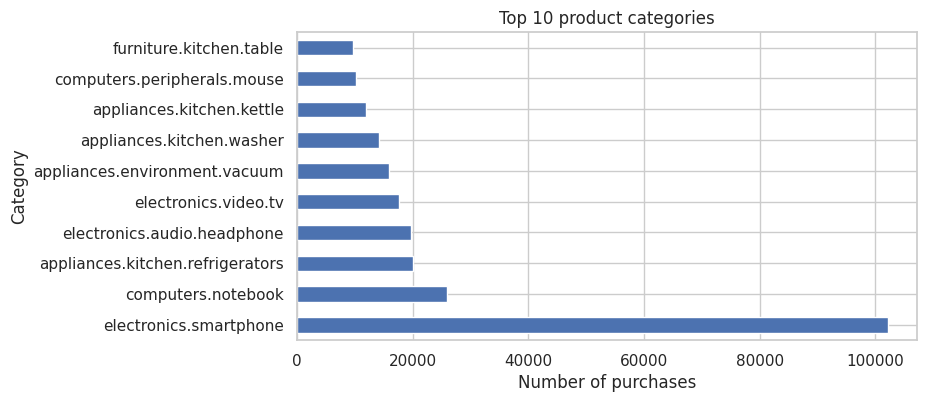

In [115]:
top_categories = (
    df["category_code"]
    .value_counts()
    .head(10)
)

top_categories.plot(
    kind="barh",
    figsize=(8, 4),
    title="Top 10 product categories"
)
plt.xlabel("Number of purchases")
plt.ylabel("Category")
plt.show()

### Топ-категории по выручке

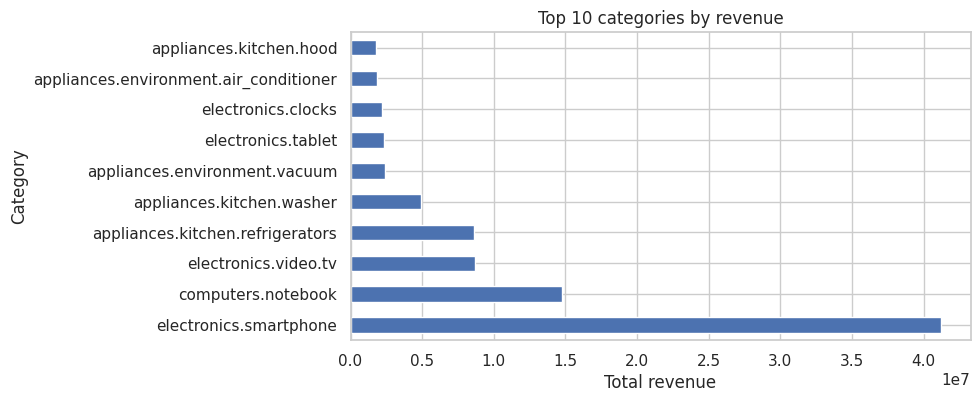

In [116]:
revenue_by_category = (
    df.groupby("category_code")["price"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

revenue_by_category.plot(
    kind="barh",
    figsize=(8, 4),
    title="Top 10 categories by revenue"
)
plt.xlabel("Total revenue")
plt.ylabel("Category")
plt.show()


### Анализ по времени (день недели, месяц)

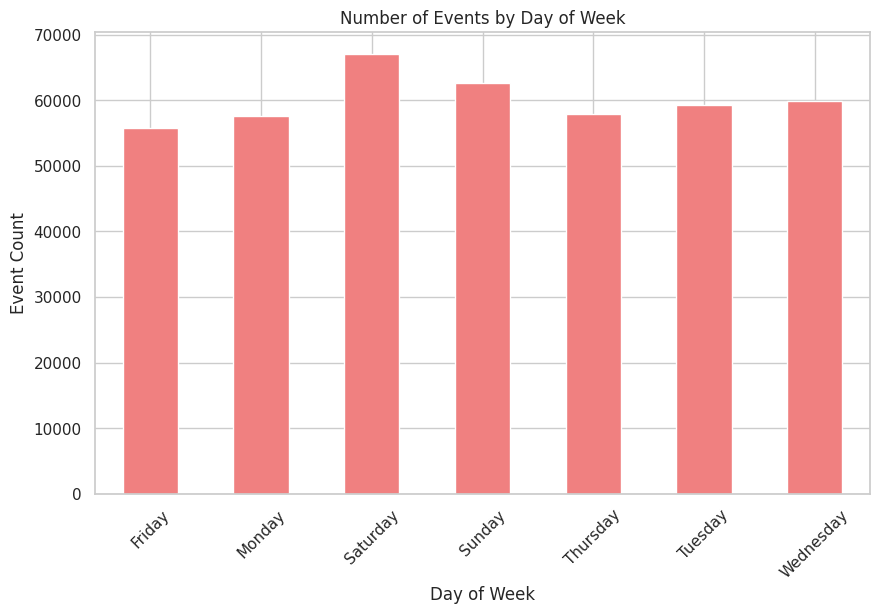

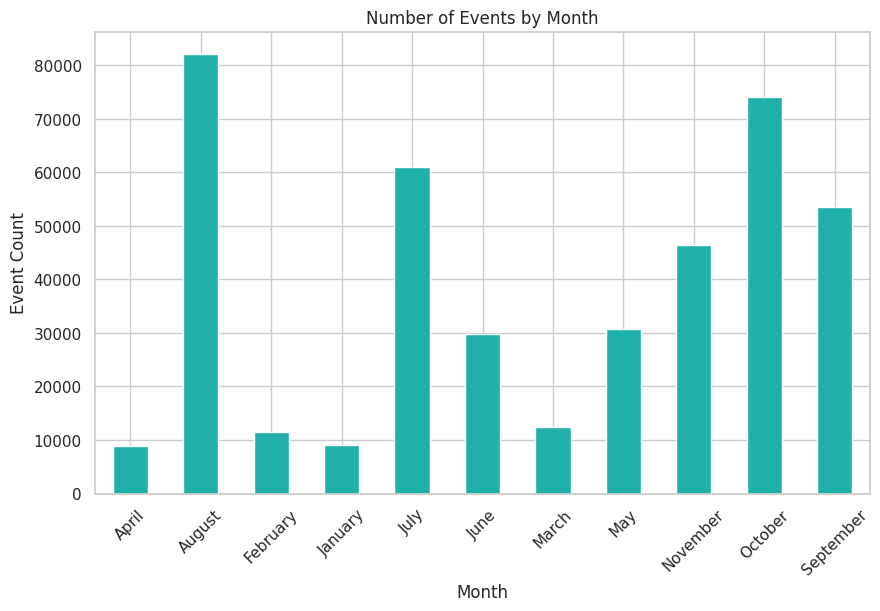

In [117]:
# Добавим столбец с днем недели и месяцем
df['day_of_week'] = df['event_time'].dt.day_name()
df['month'] = df['event_time'].dt.month_name()

# Анализ по дням недели
day_of_week_stats = df.groupby('day_of_week').size()
day_of_week_stats.plot(kind="bar", figsize=(10, 6), color="lightcoral")
plt.title('Number of Events by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.show()

# Анализ по месяцам
month_stats = df.groupby('month').size()
month_stats.plot(kind="bar", figsize=(10, 6), color="lightseagreen")
plt.title('Number of Events by Month')
plt.xlabel('Month')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.show()

### Активность по времени (часы)

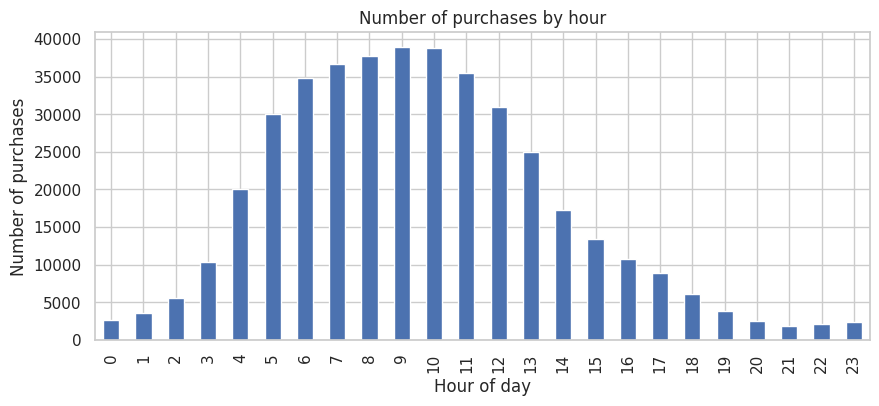

In [118]:
df["hour"] = df["event_time"].dt.hour

hourly_activity = df.groupby("hour").size()

hourly_activity.plot(
    kind="bar",
    figsize=(10, 4),
    title="Number of purchases by hour"
)
plt.xlabel("Hour of day")
plt.ylabel("Number of purchases")
plt.show()

### Распределение пользователей по RFM-сегментам

In [119]:
# Дата "среза" — обычно максимальная дата + 1 день
analysis_date = df["event_time"].max() + pd.Timedelta(days=1)
analysis_date

rfm = (
    df.groupby("user_id")
      .agg(
          recency=("event_time", lambda x: (analysis_date - x.max()).days),
          frequency=("order_id", "nunique"),
          monetary=("price", "sum")
      )
      .reset_index()
)

rfm.head()

,user_id,recency,frequency,monetary
0,1.515916e+18,136,1,416.64
1,1.515916e+18,25,2,56.43
2,1.515916e+18,5,4,5984.92
3,1.515916e+18,47,5,3785.72
4,1.515916e+18,130,2,182.83


### Нормализация RFM (квантили)

RFM расшифровывается как:

R (Recency) — Давность последней покупки (как давно клиент покупал?)

F (Frequency) — Частота покупок (как часто клиент покупает?)

M (Monetary) — Денежная ценность (сколько клиент тратит?)

In [125]:
# 4 балла = купил недавно, 1 балл = давно не покупал
rfm["R"] = pd.qcut(rfm["recency"], 4, labels=[4, 3, 2, 1])
# 4 балла = покупает часто
rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
# 4 балла = тратит много
rfm["M"] = pd.qcut(rfm["monetary"].rank(method="first"), 4, labels=[1, 2, 3, 4])

rfm[["R", "F", "M"]].head()


,R,F,M
0,1,1,2
1,4,2,1
2,4,4,4
3,4,4,4
4,1,2,2


Код присваивает каждому пользователю баллы (от 1 до 4) по трём критериям: Recency, Frequency, Monetary.

### Назначение сегментов (8 типов пользователей)

In [126]:
def rfm_segment(row):
    if row["R"] >= 4 and row["F"] >= 4 and row["M"] >= 4:
        return "High-value users"
    if row["R"] >= 3 and row["F"] >= 3:
        return "Loyal users"
    if row["F"] >= 4:
        return "Frequent users"
    if row["R"] >= 4:
        return "Recent users"
    if row["M"] >= 4:
        return "Potential users"
    if row["R"] <= 2 and row["F"] <= 2:
        return "Low-priority users"
    return "Promising users"


In [127]:
rfm["segment"] = rfm.apply(rfm_segment, axis=1)

rfm["segment"].value_counts()

segment
Low-priority users    27736
Loyal users           22101
Promising users       17856
High-value users       8001
Recent users           6502
Frequent users         4885
Potential users        3700
Name: count, dtype: int64

### Распределение пользователей по сегментам

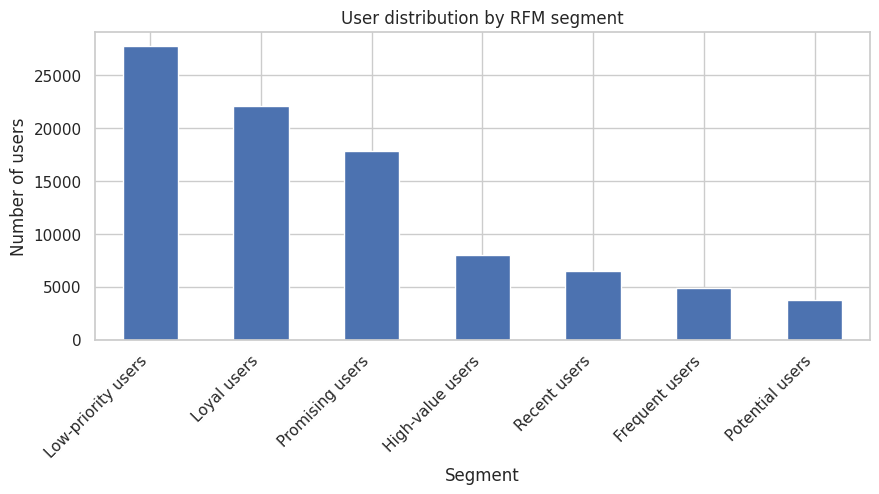

In [128]:
rfm["segment"].value_counts().plot(
    kind="bar",
    figsize=(10, 4),
    title="User distribution by RFM segment"
)
plt.xlabel("Segment")
plt.ylabel("Number of users")
plt.xticks(rotation=45, ha="right")
plt.show()

### Средний чек по сегментам

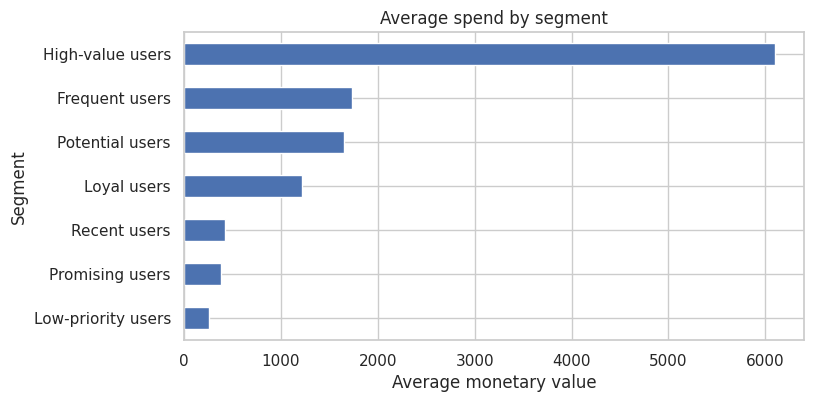

In [88]:
rfm.groupby("segment")["monetary"].mean().sort_values().plot(
    kind="barh",
    figsize=(8, 4),
    title="Average spend by segment"
)
plt.xlabel("Average monetary value")
plt.ylabel("Segment")
plt.show()


### Давность последней покупки (Recency)

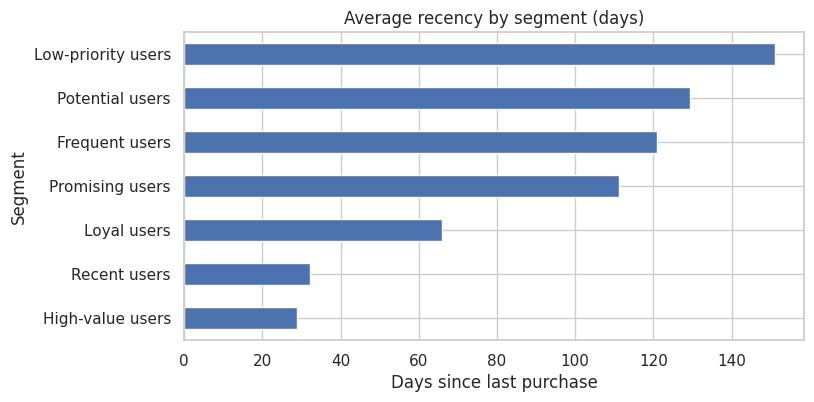

In [89]:
rfm.groupby("segment")["recency"].mean().sort_values().plot(
    kind="barh",
    figsize=(8, 4),
    title="Average recency by segment (days)"
)
plt.xlabel("Days since last purchase")
plt.ylabel("Segment")
plt.show()


Краткий вывод по результатам анализа покупок:

Время покупок: Основная часть покупок происходит с 7:00 до 11:00, с пиком в 9:00 утра.


Популярные категории: Наибольшее количество покупок сделано в категориях смартфоны, ноутбуки и телевизоры.

Распределение пользователей:

- Выделено 8 типов пользователей на основе RFM-методов.

Стратегии маркетинга должны быть адаптированы под каждый тип пользователя:

- Low-priority users — реактивация с помощью уведомлений.

- High-value users — VIP-программы и эксклюзивные предложения.

Средний чек и частота покупок:

- Пользователи с высокой ценностью (high-value) и лояльные пользователи (loyal) делают покупки чаще и тратят больше.

Рекомендации для бизнеса:

Ожидается увеличение прибыли через эксклюзивные предложения и реактивационные кампании для пользователей с низким приоритетом.

### Разделение train/test по дате

In [129]:
SPLIT_DATE = pd.Timestamp("2020-09-01", tz="UTC")

train = df[df["event_time"] < SPLIT_DATE].copy()
test = df[df["event_time"] >= SPLIT_DATE].copy()

print("train:", len(train), "rows")
print("test :", len(test), "rows")
print("users in test:", test["user_id"].nunique())

train: 245799 rows
test : 174091 rows
users in test: 31375


### Выбор k (медиана товаров повторных клиентов)

Повторный клиент = в train купил >=2 уникальных товара.

In [130]:
# сколько разных товаров купил пользователь
items_per_user = train.groupby("user_id")["product_id"].nunique()
repeat_users = items_per_user[items_per_user >= 2]

k = int(repeat_users.median()) if len(repeat_users) else 3
k = max(3, min(10, k))

k

3

### truth для теста (что купил пользователь в test)

In [131]:
truth = test.groupby("user_id")["product_id"].apply(lambda x: set(x.unique())).to_dict()
eval_users = list(truth.keys())

### Метрика F1@k = F1-score, посчитанный на топ-k рекомендациях для пользователя

In [133]:
def f1_at_k(pred_items, true_items):
    # Вычисляет F1-score для ОДНОГО пользователя
    pred_set = set(pred_items)
    if not true_items:
        return 0.0
    tp = len(pred_set & true_items)
    if tp == 0:
        return 0.0
    precision = tp / max(len(pred_set), 1)
    recall = tp / len(true_items)
    return 2 * precision * recall / (precision + recall)

def macro_f1(preds, truth_dict):
    # Вычисляет среднее F1-score по ВСЕМ пользователям
    scores = []
    for u, true_items in truth_dict.items():
        scores.append(f1_at_k(preds.get(u, []), true_items))
    return float(np.mean(scores)) if scores else 0.0


## Часть 1 — Наивные модели

### Наивный 1: Top-k популярных товаров

In [135]:
# Находим k самых популярных товаров во всём датасете
topk_items = train["product_id"].value_counts().head(k).index.tolist()
# Рекомендуем эти же товары всем пользователям
pred_topk = {u: topk_items for u in eval_users}
f1_topk = macro_f1(pred_topk, truth)

f1_topk

0.006231022687272795

### Наивный 2: Любимый товар + (k-1) популярных

In [136]:
fav_item = (
    train.groupby(["user_id", "product_id"])
         .size()
         .reset_index(name="cnt")
         .sort_values("cnt", ascending=False)
         .drop_duplicates("user_id")
         .set_index("user_id")["product_id"]
         .to_dict()
)

pred_fav = {}
for u in eval_users:
    recs = []
    if u in fav_item:
        recs.append(fav_item[u])
    for it in topk_items:
        if len(recs) >= k:
            break
        if it not in recs:
            recs.append(it)
    pred_fav[u] = recs[:k]

f1_fav = macro_f1(pred_fav, truth)
f1_fav


0.012208010766707581

### Наивный 3: Случайные по распределению популярности

In [33]:
rng = np.random.default_rng(42)

vc = train["product_id"].value_counts()
items = vc.index.to_numpy()
# Превращаем количество покупок в вероятности (от 0 до 1)
probs = (vc.values / vc.values.sum()).astype(float)

pred_rand = {}
for u in eval_users:
    if len(items) <= k:
        pred_rand[u] = items.tolist()
    else:
        pred_rand[u] = rng.choice(items, size=k, replace=False, p=probs).tolist()

f1_rand = macro_f1(pred_rand, truth)
f1_rand


0.001800826105961539

## Часть 2 — Продвинутая модель (SVD / совместная фильтрация)

### User–Item матрица train (implicit)

In [137]:
users = train["user_id"].unique()
items_all = train["product_id"].unique()

# Превращаем ID в индексы (0, 1, 2, 3...)
user_to_idx = {u: i for i, u in enumerate(users)}
item_to_idx = {it: j for j, it in enumerate(items_all)}

# сколько раз каждый пользователь купил каждый товар
grp = train.groupby(["user_id", "product_id"]).size().reset_index(name="cnt")

row = grp["user_id"].map(user_to_idx).to_numpy()
col = grp["product_id"].map(item_to_idx).to_numpy()
data = grp["cnt"].astype(float).to_numpy()

# создаём разреженную матрицу
X = sparse.csr_matrix((data, (row, col)), shape=(len(users), len(items_all)))

# log(1+cnt) — стандартно для implicit
Xw = X.copy().astype(np.float32)
Xw.data = np.log1p(Xw.data)

Xw.shape


(73499, 9475)

### Fit SVD

In [151]:
n_users, n_items = Xw.shape

n_components = 50

svd = TruncatedSVD(n_components=n_components, random_state=42)
U = svd.fit_transform(Xw)     # (users, k)
V = svd.components_.T         # (items, k)

# нормировка
U = U / (np.linalg.norm(U, axis=1, keepdims=True) + 1e-12)
V = V / (np.linalg.norm(V, axis=1, keepdims=True) + 1e-12)

idx_to_item = np.array(items_all, dtype=object)

U.shape, V.shape


((73499, 50), (9475, 50))

### Рекомендации SVD top-k (исключаем товары из train)

In [156]:
def recommend_svd(u: str, k: int):
    if u not in user_to_idx:
        return topk_items[:]
    
    uidx = user_to_idx[u]
    scores = V @ U[uidx]
    
    top_idx = np.argpartition(-scores, kth=k-1)[:k]
    top_idx = top_idx[np.argsort(-scores[top_idx])]
    
    return idx_to_item[top_idx].astype(int).tolist()

### Оценка SVD по F1-Score

In [157]:
pred_svd = {u: recommend_svd(u, k) for u in eval_users}
f1_svd = macro_f1(pred_svd, truth)

f1_svd

0.01010447755534642

## Результаты

## Примеры рекомендаций

In [158]:
results = pd.DataFrame([
    {"model": f"Naive: Top-{k} popular", "macro_f1": f1_topk},
    {"model": "Naive: Favorite + popular", "macro_f1": f1_fav},
    {"model": "Naive: Random by popularity", "macro_f1": f1_rand},
    {"model": "Advanced: SVD (implicit)", "macro_f1": f1_svd},
]).sort_values("macro_f1", ascending=False)

results

,model,macro_f1
1,Naive: Favorite + popular,0.012208
3,Advanced: SVD (implicit),0.010104
0,Naive: Top-3 popular,0.006231
2,Naive: Random by popularity,0.001801


In [159]:
for u in eval_users[:10]:
    print("user:", u)
    print("truth size:", len(truth[u]))
    print("naive fav:", pred_fav[u])
    print("svd     :", pred_svd[u])
    print()


user: 1.5159156254400384e+18
truth size: 2
naive fav: [1515966223509104145, 1515966223509106786, 1515966223509088620]
svd     : [1515966223509104145, 1515966223509106786, 1515966223509088620]

user: 1.5159156254400515e+18
truth size: 11
naive fav: [1515966223509104145, 1515966223509106786, 1515966223509088620]
svd     : [1515966223509104145, 1515966223509106786, 1515966223509088620]

user: 1.5159156254400998e+18
truth size: 4
naive fav: [1515966223509088564, 1515966223509104145, 1515966223509106786]
svd     : [1515966223509088564, 2273948226144961353, 2334256869540888700]

user: 1.5159156254408814e+18
truth size: 10
naive fav: [1515966223509392246, 1515966223509104145, 1515966223509106786]
svd     : [2273948233552101643, 1515966223509392246, 2273948310232367543]

user: 1.5159156254409362e+18
truth size: 5
naive fav: [1515966223509104280, 1515966223509104145, 1515966223509106786]
svd     : [1515966223509104280, 1515966223509128701, 1515966223509090002]

user: 1.515915625440937e+18
truth

In [144]:
n_users = len(users)
n_items = len(items_all)
n_interactions = len(train)

sparsity = 1 - (n_interactions / (n_users * n_items))
print(f"Разреженность: {sparsity:.4%}")


Разреженность: 99.9647%


Из 100% возможных комбинаций user-item заполнено только 0.035%
99.96% матрицы — пустые ячейки

Параметр k был выбран на основе поведения повторных клиентов и в эксперименте равен k=3.

Были реализованы наивные модели рекомендаций:

Top-k популярных товаров

Любимый товар пользователя + (k−1) популярных

Случайные товары с учётом распределения популярности

В качестве метрики использована Macro F1@k (F1-score по top-k рекомендациям, усреднённый по пользователям теста).

По результатам сравнения моделей:

Naive: Favorite + popular показала лучший результат: Macro F1@3 = 0.0122